# Validate

Colab to infere satellite images from mask pictures using a trained pix2pix model based on the code found in https://github.com/mrzhu-cool/pix2pix-pytorch

## Imports and parameters

### Imports

In [ ]:
# Accessing the files and preparing the dataset
from google.colab import drive
from os import listdir
from os.path import join
import os

# Treating the images
from PIL import Image
import numpy as np
import random
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# Dealing with GPUs
import torch.backends.cudnn as cudnn

# Defining the networks
import torch.nn as nn
from torch.nn import init
import functools
from torch.optim import lr_scheduler
import torch.optim as optim

# Training
from math import log10
import time
import math

# Tensorboard
from torch.utils.tensorboard import SummaryWriter
import datetime

### Parameters

In [ ]:
import argparse

# Training settings
parser = argparse.ArgumentParser(description='pix2pix-pytorch-implementation')
# In the original code, dataset is required. We don't need it for the Inria Aerial Image Labelling Dataset
parser.add_argument('--dataset', required=False, help='facades')
parser.add_argument('--batch_size', type=int, default=1, help='training batch size')
parser.add_argument('--test_batch_size', type=int, default=1, help='testing batch size')
parser.add_argument('--direction', type=str, default='a2b', help='a2b or b2a')
parser.add_argument('--input_nc', type=int, default=3, help='input image channels')
parser.add_argument('--output_nc', type=int, default=3, help='output image channels')
parser.add_argument('--ngf', type=int, default=64, help='generator filters in first conv layer')
parser.add_argument('--ndf', type=int, default=64, help='discriminator filters in first conv layer')
# Training epochs are defined by range(opt.epoch_count, opt.niter + opt.niter_decay + 1)
# So, originally, the training script epochs from 1 to 201, which takes too long at the beginning
# niter and niter_decay are changed to shorten the amount of time during development
parser.add_argument('--epoch_count', type=int, default=1, help='the starting epoch count')
parser.add_argument('--niter', type=int, default=100, help='# of iter at starting learning rate') # 100
parser.add_argument('--niter_decay', type=int, default=100, help='# of iter to linearly decay learning rate to zero') # 100
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate for adam') # 0.0002
parser.add_argument('--lr_policy', type=str, default='lambda', help='learning rate policy: lambda|step|plateau|cosine')
parser.add_argument('--lr_decay_iters', type=int, default=50, help='multiply by a gamma every lr_decay_iters iterations')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for adam. default=0.5')
parser.add_argument('--cuda', action='store_true', help='use cuda?')
parser.add_argument('--threads', type=int, default=1, help='number of threads for data loader to use')
parser.add_argument('--seed', type=int, default=123, help='random seed to use. Default=123')
parser.add_argument('--lamb', type=int, default=10, help='weight on L1 term in objective') # 10
# Activate or deactivate the use of Tensorboard
parser.add_argument('--tb_active', type=bool, default=True, help='should tensorboard be used') # Deactivate for deep trainings
# Which original image should be stored in Tensorboard.
# Inria satellite images are 5000x5000 and consume much CPU and memory, so only
# one image is saved to avoid using too many resources
parser.add_argument('--tb_image', type=str, default='vienna1.tif', help='image to store in tensorboard')
# Number of images saved to tensorboard. Only tb_image will be saved, so the progress
# of generated images can be seen throw epochs. 5 images in 100 epochs means one
# tb_image will be saved every 20 epochs.
parser.add_argument('--tb_number_img', type=int, default=5, help='number of images saved to tensorboard')
# Level of debug (cell output)
parser.add_argument('--debug', type=int, default=1, help='level of debug from 0 (no debug) to 2 (verbose)')
# Number of iteration messages per epoch. They have the form
# ===> Epoch[{}]({}/{}): Loss_D: {:.4f} Loss_G: {:.4f}
parser.add_argument('--iter_messages', type=int, default=4, help='number of output messages per epoch')
# Number of epochs to save a checkpoint
parser.add_argument('--checkpoint_epochs', type=int, default=50, help='number of epochs to save a checkpoint')
# Stop training after checkpoint is saved. Useful in long trainings
parser.add_argument('--stop_after_checkpoint', type=bool, default=True, help='stop training after a checkpoint has been saved')

# As stated in https://stackoverflow.com/questions/48796169/how-to-fix-ipykernel-launcher-py-error-unrecognized-arguments-in-jupyter
# at least an empty list must be passed to simulate a script execution with no parameters.
# If no parameter is provided, parse_args tries to read _sys.argv[1:], which is not defined
# in a colab execution
training_args = ['--cuda',
                 '--epoch_count=101',
                 '--niter=250',
                 '--niter_decay=250',
                 '--lr=0.002',
                 '--lamb=1',
                 '--direction=a2b',
                 '--batch_size=10',
                 '--checkpoint_epochs=4',
                 '--threads=0',
                 '--debug=1',
                 '--tb_number_img=500']
opt = parser.parse_args(training_args)

train_dir = 'dataset/train'
train_gt_dir = train_dir + '/gt'
train_images_dir = train_dir + '/images'
train_tensorboard_dir = train_dir + '/log'

test_dir = 'dataset/test'
test_gt_dir = test_dir + '/gt'
test_images_dir = test_dir + '/images'
test_tensorboard_dir = test_dir + '/log'

In [ ]:
if opt.cuda and not torch.cuda.is_available():
    raise Exception("No GPU found, please run without --cuda")

# cudnn.benchmark = True

# torch.manual_seed(opt.seed)
# if opt.cuda:
#     torch.cuda.manual_seed(opt.seed)

device = torch.device("cuda:0" if opt.cuda else "cpu")

### Debug function

In [ ]:
def print_debug(level, text):
    """
    Prints a debug message only if the level of the message is lower or equal
    to the debug level set in global variable debug
    """
    # Accessing the global debug variable
    # global debug
    # The text will only be
    if level <= opt.debug:
        print("  [DEBUG] " + text)

## Accessing the dataset

### Connecting to Google Drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining the networks

### get_norm_layer

In [ ]:
def get_norm_layer(norm_type='instance'):
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True)
    elif norm_type == 'instance':
        norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
    elif norm_type == 'switchable':
        norm_layer = SwitchNorm2d
    elif norm_type == 'none':
        norm_layer = None
    else:
        raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
    return norm_layer

### get_scheduler

In [ ]:
def get_scheduler(optimizer, opt):
    if opt.lr_policy == 'lambda':
        def lambda_rule(epoch):
            lr_l = 1.0 - max(0, epoch + opt.epoch_count - opt.niter) / float(opt.niter_decay + 1)
            return lr_l
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)
    elif opt.lr_policy == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=opt.lr_decay_iters, gamma=0.1)
    elif opt.lr_policy == 'plateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, threshold=0.01, patience=5)
    elif opt.lr_policy == 'cosine':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=opt.niter, eta_min=0)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', opt.lr_policy)
    return scheduler

### update_learning_rate

In [ ]:
# update learning rate (called once every epoch)
def update_learning_rate(scheduler, optimizer):
    scheduler.step()
    lr = optimizer.param_groups[0]['lr']
    print('learning rate = %.7f' % lr)

### init_weights

In [ ]:
def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

### init_net

In [ ]:
def init_net(net, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net.to(gpu_id)
    init_weights(net, init_type, gain=init_gain)
    return net

### define_G

In [ ]:
def define_G(input_nc, output_nc, ngf, norm='batch', use_dropout=False, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    net = ResnetGenerator(input_nc, output_nc, ngf, norm_layer=norm_layer, use_dropout=use_dropout, n_blocks=9)
   
    return init_net(net, init_type, init_gain, gpu_id)

### Class ResnetGenerator

In [ ]:
# Defines the generator that consists of Resnet blocks between a few
# downsampling/upsampling operations.
class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=9, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.inc = Inconv(input_nc, ngf, norm_layer, use_bias)
        self.down1 = Down(ngf, ngf * 2, norm_layer, use_bias)
        self.down2 = Down(ngf * 2, ngf * 4, norm_layer, use_bias)

        model = []
        for i in range(n_blocks):
            model += [ResBlock(ngf * 4, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]
        self.resblocks = nn.Sequential(*model)

        self.up1 = Up(ngf * 4, ngf * 2, norm_layer, use_bias)
        self.up2 = Up(ngf * 2, ngf, norm_layer, use_bias)

        self.outc = Outconv(ngf, output_nc)

    def forward(self, input):
        out = {}
        # DTT No hay skip connections?
        out['in'] = self.inc(input)
        out['d1'] = self.down1(out['in'])
        out['d2'] = self.down2(out['d1'])
        out['bottle'] = self.resblocks(out['d2'])
        out['u1'] = self.up1(out['bottle'])
        out['u2'] = self.up2(out['u1'])

        return self.outc(out['u2'])

### Class Inconv

In [ ]:
class Inconv(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Inconv, self).__init__()
        self.inconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, out_ch, kernel_size=7, padding=0,
                      bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.inconv(x)
        return x

### Class Down

In [ ]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3,
                      stride=2, padding=1, bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.down(x)
        return x

### Class ResBlock

In [ ]:
# Define a Resnet block
class ResBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim),
                       nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        # DTT 'x +' === skip connection!!
        out = x + self.conv_block(x)
        return nn.ReLU(True)(out)

### Class Up

In [ ]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, norm_layer, use_bias):
        super(Up, self).__init__()
        self.up = nn.Sequential(
            # nn.Upsample(scale_factor=2, mode='nearest'),
            # nn.Conv2d(in_ch, out_ch,
            #           kernel_size=3, stride=1,
            #           padding=1, bias=use_bias),
            nn.ConvTranspose2d(in_ch, out_ch,
                               kernel_size=3, stride=2,
                               padding=1, output_padding=1,
                               bias=use_bias),
            norm_layer(out_ch),
            nn.ReLU(True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

### Class Outconv

In [ ]:
class Outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(Outconv, self).__init__()
        self.outconv = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_ch, out_ch, kernel_size=7, padding=0),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.outconv(x)
        return x

### define_D

In [ ]:
def define_D(input_nc, ndf, netD,
             n_layers_D=3, norm='batch', use_sigmoid=False, init_type='normal', init_gain=0.02, gpu_id='cuda:0'):
    net = None
    norm_layer = get_norm_layer(norm_type=norm)

    if netD == 'basic':
        net = NLayerDiscriminator(input_nc, ndf, n_layers=3, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    elif netD == 'n_layers':
        net = NLayerDiscriminator(input_nc, ndf, n_layers_D, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    elif netD == 'pixel':
        net = PixelDiscriminator(input_nc, ndf, norm_layer=norm_layer, use_sigmoid=use_sigmoid)
    else:
        raise NotImplementedError('Discriminator model name [%s] is not recognized' % net)

    return init_net(net, init_type, init_gain, gpu_id)

### Class NLayerDiscriminator

In [ ]:
# Defines the PatchGAN discriminator with the specified arguments.
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2**n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                          kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2**n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult,
                      kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        if use_sigmoid:
            sequence += [nn.Sigmoid()]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)

### Class PixelDiscriminator

In [ ]:
class PixelDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, norm_layer=nn.BatchNorm2d, use_sigmoid=False):
        super(PixelDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        self.net = [
            nn.Conv2d(input_nc, ndf, kernel_size=1, stride=1, padding=0),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=1, stride=1, padding=0, bias=use_bias),
            norm_layer(ndf * 2),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(ndf * 2, 1, kernel_size=1, stride=1, padding=0, bias=use_bias)]

        if use_sigmoid:
            self.net.append(nn.Sigmoid())

        self.net = nn.Sequential(*self.net)

    def forward(self, input):
        return self.net(input)

### Class GANLoss

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, use_lsgan=True, target_real_label=1.0, target_fake_label=0.0):
        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        if use_lsgan:
            self.loss = nn.MSELoss()
        else:
            self.loss = nn.BCELoss()

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(input)

    def __call__(self, input, target_is_real):
        target_tensor = self.get_target_tensor(input, target_is_real)
        return self.loss(input, target_tensor)


### Creating the networks

In [ ]:
# NOP

# Creating the networks from scratch
net_g = define_G(opt.input_nc, opt.output_nc, opt.ngf, 'batch', False, 'normal', 0.02, gpu_id=device)
net_d = define_D(opt.input_nc + opt.output_nc, opt.ndf, 'basic', gpu_id=device)

criterionGAN = GANLoss().to(device)
criterionL1 = nn.L1Loss().to(device)
criterionMSE = nn.MSELoss().to(device)

# setup optimizer
optimizer_g = optim.Adam(net_g.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizer_d = optim.Adam(net_d.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
net_g_scheduler = get_scheduler(optimizer_g, opt)
net_d_scheduler = get_scheduler(optimizer_d, opt)

initialize network with normal
initialize network with normal


## Auxiliary functions

### denormalize_image & show_image

In [ ]:
def denormalize_image(image_tensor):
    """
    Denormalizes an image coming from the network, usually, a generated image

    Parameters
    ----------
    images_tensor: tensor representing a PIL image
    """
    print_debug(2, "denormalize_image image tensor shape: {}".format(image_tensor.shape))
    # cpu() to avoid error "can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first."
    image_numpy = image_tensor.cpu().data.float().numpy()
    
            # La transformación inversa sería simplemente min( (x*0.5)+0.5), 1)
            # (haciendo un clipping de los valores para que no nos salgan colores raros).
            # Tensorboard creo que ya gestiona lo del clipping;
            # pero viene de nuestra cuenta hacer la "desnormalización".

    print_debug(2, "denormalize_image image_numpy shape: {}".format(image_numpy.shape))
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + 1) / 2.0 * 255.0
    print_debug(2, "denormalize_image image_numpy shape: {} after transposing".format(image_numpy.shape))
    image_numpy = image_numpy.clip(0, 255)
    print_debug(2, "denormalize_image image_numpy shape: {} after clipping".format(image_numpy.shape))
    image_numpy = image_numpy.astype(np.uint8)
    print_debug(2, "denormalize_image image_numpy shape: {} after converting to uint8".format(image_numpy.shape))

    return image_numpy

def show_image(image_tensor):
    """
    Shows an image coming from the network

    Parameters
    """
    image_numpy = denormalize_image(image_tensor)
    pil_image = Image.fromarray(image_numpy)
    imshow(pil_image)        

### Show list/tuple of images in a grid

In [ ]:
# NOP

# Based on utils.py save_img and the last answer in
# https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645#46616645
# Plots several figures in a tile
def show_images_grid(images_tuple, nrows=1, ncols=1):
    """
    Shows several images coming from a DataLoader based on DatasetFromFolder
    in a tile

    Parameters
    ----------
    images_tuple: tuple of tensors representing images
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15,15))
    for ind,image_tensor in zip(range(len(images_tuple)), images_tuple):
        # First, denormalize image to allow it to be printable
        image_numpy = denormalize_image(image_tensor)
        image_pil = Image.fromarray(image_numpy)
        # imshow(image_pil)
        
        axeslist.ravel()[ind].imshow(image_pil, cmap=plt.jet())
        # axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

## Loading previous trained checkpoint

In [ ]:
!ls drive/MyDrive/"Colab Notebooks"/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/net*.pth


'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_100.pth'
'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_200.pth'
'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_300.pth'
'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_400.pth'
'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_500.pth'
'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_600.pth'
'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_700.pth'
'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_800.pth'
'drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netD_model_epoch_900.pth'
'drive/MyDrive/Colab Noteboo

In [ ]:
# Loading already calculated weights
# net_g = torch.load('drive/MyDrive/Colab Notebooks/AIDL/Project/train/trainedModels/netG_model_epoch_100.pth', map_location=torch.device(device)).to(device)
# net_g = torch.load('drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netG_model_epoch_600.pth', map_location=torch.device(device)).to(device)
net_g = torch.load('drive/MyDrive/Colab Notebooks/AIDL/Project/AerialImageDataset-pix2pix/checkpoint/netG_model_epoch_900.pth', map_location=torch.device(device)).to(device)
# net_d = torch.load('drive/MyDrive/Colab Notebooks/AIDL/Project/train/trainedModels/netD_model_epoch_100.pth', map_location=torch.device(device)).to(device)

## Validating with images

In [ ]:
common_path = 'drive/MyDrive/Colab Notebooks/AIDL/Project/train/'
mask_image_path      = common_path + 'gt/vienna29.tif' # 11 or 29
satellite_image_path = common_path + 'images/vienna29.tif'


### Show mask

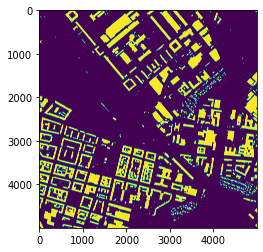

In [ ]:
mask_image = Image.open(mask_image_path)
imshow(mask_image)

### Show ground truth

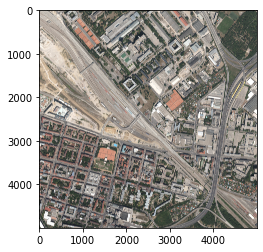

In [ ]:
satellite_image = Image.open(satellite_image_path)
imshow(satellite_image)

### Generate image and show it

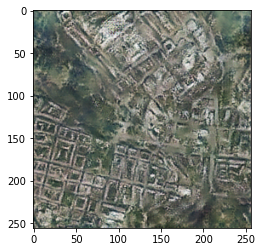

In [ ]:
transform_list = [transforms.ToTensor(),
                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]

transform = transforms.Compose(transform_list)

# 1. The mask image has only one channel. The generator (and the transforms.Normalize)
#    expect 3 channel images

# 2. Non 256x256 images break the generator with "CUDA out of memory. Tried to allocate
#    2.98 GiB (GPU 0; 14.73 GiB total capacity; 12.54 GiB already allocated;
#    1.25 GiB free; 12.54 GiB reserved in total by PyTorch)"
#    So, the mask is resized
rgb_mask_image = mask_image.convert('RGB').resize((256, 256), Image.BICUBIC)
img = transform(rgb_mask_image)
input = img.unsqueeze(0).to(device)
out = net_g(input)
generated_image = out.detach().squeeze(0).cpu()

show_image(generated_image)